In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, EfficientNetB3
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
import shutil
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

2025-05-12 06:56:46.541700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747033006.758639      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747033006.818118      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
TARGET_CLASS = 'CNV' 

In [3]:
BASE_PATH = '/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VAL_PATH = os.path.join(BASE_PATH, 'val')
TEST_PATH = os.path.join(BASE_PATH, 'test')

TEMP_DIR = '/kaggle/working/temp_data'


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
MODEL_NAME = 'vgg16' 

In [5]:
def prepare_binary_dataset(target_class):
    if os.path.exists(TEMP_DIR):
        shutil.rmtree(TEMP_DIR)
    
    os.makedirs(f'{TEMP_DIR}/train/{target_class}', exist_ok=True)
    os.makedirs(f'{TEMP_DIR}/train/OTHER', exist_ok=True)
    os.makedirs(f'{TEMP_DIR}/val/{target_class}', exist_ok=True)
    os.makedirs(f'{TEMP_DIR}/val/OTHER', exist_ok=True)
    os.makedirs(f'{TEMP_DIR}/test/{target_class}', exist_ok=True)
    os.makedirs(f'{TEMP_DIR}/test/OTHER', exist_ok=True)

    def copy_images(source_dir, subset):
        for class_name in os.listdir(source_dir):
            src = os.path.join(source_dir, class_name)
            for img_file in tqdm(os.listdir(src), desc=f'Processing {subset} - {class_name}'):
                dest_label = target_class if class_name == target_class else 'OTHER'
                dest = os.path.join(TEMP_DIR, subset, dest_label)
                shutil.copy(os.path.join(src, img_file), os.path.join(dest, img_file))

    copy_images(TRAIN_PATH, 'train')
    copy_images(VAL_PATH, 'val')
    copy_images(TEST_PATH, 'test')

prepare_binary_dataset(TARGET_CLASS)


Processing test - DME: 100%|██████████| 1161/1161 [00:10<00:00, 109.87it/s]


In [6]:
train_aug = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
)

val_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_directory(
    os.path.join(TEMP_DIR, 'train'),
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_gen = val_aug.flow_from_directory(
    os.path.join(TEMP_DIR, 'val'),
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_gen = val_aug.flow_from_directory(
    os.path.join(TEMP_DIR, 'test'),
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 76515 images belonging to 2 classes.
Found 21861 images belonging to 2 classes.
Found 10933 images belonging to 2 classes.


In [7]:
def build_model(name='vgg16'):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,), pooling='avg') if name == 'vgg16' else EfficientNetB3(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,), pooling='avg')

    base_model.trainable = False  # You can fine-tune later

    model = models.Sequential([
        base_model,
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )
    return model

model = build_model(MODEL_NAME)
model.summary()


I0000 00:00:1747034021.376006      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,321 (56.64 MB)

 Trainable params: 132,609 (518.00 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [8]:
early_stop = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747034029.644692     113 service.cc:148] XLA service 0x7c6a3000ed70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747034029.645447     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747034030.061252     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2392 ━━━━━━━━━━━━━━━━━━━━ 3:05 77ms/step - accuracy: 0.6016 - loss: 0.7084  

I0000 00:00:1747034038.562474     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2392/2392 ━━━━━━━━━━━━━━━━━━━━ 1036s 427ms/step - accuracy: 0.8669 - loss: 0.3063 - val_accuracy: 0.9236 - val_loss: 0.1890
Epoch 2/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 1035s 432ms/step - accuracy: 0.9178 - loss: 0.2038 - val_accuracy: 0.9321 - val_loss: 0.1700
Epoch 3/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 996s 415ms/step - accuracy: 0.9250 - loss: 0.1853 - val_accuracy: 0.9341 - val_loss: 0.1610
Epoch 4/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 989s 412ms/step - accuracy: 0.9290 - loss: 0.1753 - val_accuracy: 0.9363 - val_loss: 0.1562
Epoch 5/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 993s 414ms/step - accuracy: 0.9300 - loss: 0.1744 - val_accuracy: 0.9374 - val_loss: 0.1544
Epoch 6/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 983s 410ms/step - accuracy: 0.9318 - loss: 0.1692 - val_accuracy: 0.9403 - val_loss: 0.1507
Epoch 7/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 989s 412ms/step - accuracy: 0.9326 - loss: 0.1664 - val_accuracy: 0.9405 - val_loss: 0.1470
Epoch 8/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 996s 415ms/step - accuracy: 0

In [9]:
loss, acc = model.evaluate(test_gen)
print(f'Test Accuracy: {acc * 100:.2f}%')

# Save model
model.save(f'/kaggle/working/{TARGET_CLASS.lower()}_model.keras')
print("✅ Saved model as:", f'{TARGET_CLASS.lower()}_model.keras')


342/342 ━━━━━━━━━━━━━━━━━━━━ 34s 99ms/step - accuracy: 0.9272 - loss: 0.1833
Test Accuracy: 94.77%


342/342 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step


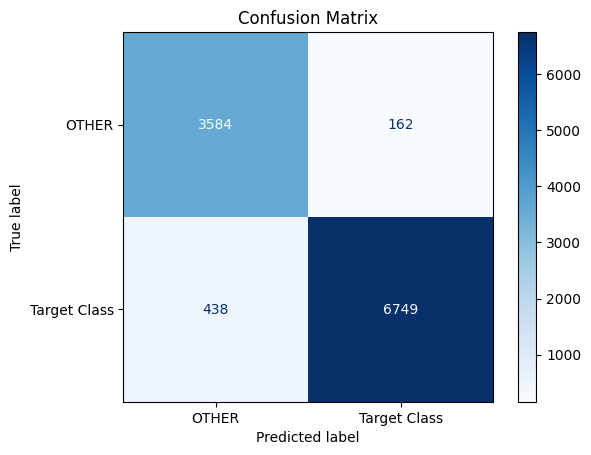

📊 Classification Report:
              precision    recall  f1-score   support

       OTHER       0.89      0.96      0.92      3746
      Target       0.98      0.94      0.96      7187

    accuracy                           0.95     10933
   macro avg       0.93      0.95      0.94     10933
weighted avg       0.95      0.95      0.95     10933

🧠 AUC-ROC Score: 0.9889


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get ground truth and predictions
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs > 0.7).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["OTHER", "Target Class"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report (Precision, Recall, F1)
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["OTHER", "Target"]))

# AUC-ROC Score
auc = roc_auc_score(y_true, y_pred_probs)
print(f"🧠 AUC-ROC Score: {auc:.4f}")


In [12]:
import shutil
shutil.copy('/kaggle/working/best_model.keras', '/kaggle/working/cnv_model.keras')


'/kaggle/working/cnv_model.keras'